In [2]:
import os
import utils
import torch
from models import GAT, SpGAT
import torch.nn.functional as F
import sklearn.metrics
import numpy as np
from torch.autograd import Variable
import pandas as pd
import numpy as np
from data.utils import record_result, mouse_ensg_to_symbol
import random
import scprep
import phate

In [12]:
dirs = [x for x in os.listdir('joshi_results/cd8a/') if x.startswith('0')]
count_df = pd.read_csv('../data/datastore/week8_ln_raw_expr.csv', index_col=0)
label_df = pd.read_csv('../data/datastore/week8_ln_magic_expr.csv', index_col=0)

In [4]:
gene_symbol = mouse_ensg_to_symbol(datastore="../data") # ensembl to symbol
ensembl = dict((v,k) for k,v in gene_symbol.items()) # symbol to ensembl

In [5]:
adj, features, labels, _, _, _, neighbor_genes = utils.load_joshi_data("Cd8a")
features, adj, labels = Variable(features), Variable(adj), Variable(labels)

 loading from cache file../data/graphs/stringdb_all_mouse_graph_edges.adjlist


In [6]:
model = GAT(ncells = features.shape[0], #features is cells x gene x gene features
                ngenes=features.shape[1], 
                nfeat=features.shape[2],
                nhid=1, 
                nclass=1, # regression
                dropout=0.6, 
                nheads=1, 
                alpha=0.2)

model

GAT(
  (out_att): GraphAttentionLayer (1 -> 1)
)

In [14]:
def loss_fn(output, labels, attention, lam):
    reconstruction = F.smooth_l1_loss(output, labels.float()).float()

    return (reconstruction)

In [15]:
def compute_test(lam=0.0):
    model.eval()
    output, attention = model(features, adj)

    output = output.reshape(-1)
    loss_test = loss_fn(output[idx_test], labels[idx_test], attention, lam)
    r2_test = sklearn.metrics.r2_score(labels[idx_test].cpu(), output[idx_test].cpu().detach().numpy())
    l0_norm_att_test = sum(~np.isclose(attention[idx_test][0].cpu().detach().numpy().flatten(), np.zeros((attention.cpu().detach().numpy().shape[1])), atol=0.0015))

    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "r2_test= {:.4f}".format(r2_test),
          "l0_norm_att_test: {}".format(l0_norm_att_test))
    
    return output[idx_test], labels[idx_test], attention[idx_test]

### Best R^2, learning rate = 0.2, patience = 150

In [30]:
d = '0.0.0.2.150'
idx_test = np.load('joshi_results/cd8a/{}/idx_test_joshi.npy'.format(d))
f = [x for x in os.listdir('joshi_results/cd8a/{}'.format(d)) if x.endswith('pkl')][0]
curr_model = torch.load('joshi_results/cd8a/{}/{}'.format(d,f))
neighbor_genes = np.load('joshi_results/cd8a/{}/neighbor_genes_joshi.npy'.format(d), allow_pickle=True)
model.load_state_dict(curr_model)
output_model, labels_model, attention_model = compute_test(lam=0.0)

Test set results: loss= 0.0114 r2_test= 0.3071 l0_norm_att_test: 307


In [31]:
x = output_model.detach().numpy()
y = labels_model.detach().numpy()
sum(np.isclose(x,y, atol=0.2)) / x.shape[0]

0.8348837209302326

In [50]:
attention = attention_model.detach().numpy().mean(axis=0).flatten()[:-1]

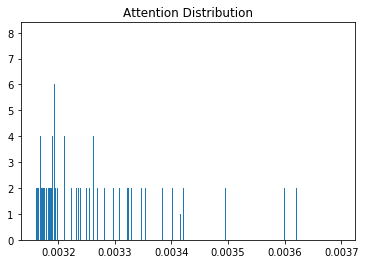

In [12]:
import matplotlib.pyplot as plt
plt.hist(attention, bins=1000)
plt.title('Attention Distribution')
plt.savefig('attention_ditribution', dpi=300)

In [13]:
top_gene_idx = attention.argsort()[::-1][:50]

In [14]:
top_neighbor_genes = neighbor_genes[top_gene_idx]

In [15]:
[gene_symbol[x] for x in top_neighbor_genes]

['Cd3d',
 'Gm10184',
 'Cd40lg',
 'Echs1',
 'Ly6c2',
 'Bst2',
 'Lag3',
 'Ctsw',
 'Itgal',
 'Jak2',
 'Tnfsf4',
 'Ifit1',
 'Ptprc',
 'Smad7',
 'Cd80',
 'Ifit1bl2',
 'Gapdh',
 'Serpinc1',
 'Cd84',
 'Afdn',
 'Nfkb2',
 'Klra1',
 'Serpinb9',
 'Gzma',
 'Stk16',
 'Cd274',
 'Satb1',
 'Dock2',
 'Il2ra',
 'Flt3',
 'H2-Q7',
 'Ccr6',
 'Chpt1',
 'Fas',
 'Ikzf1',
 'Cd244a',
 'Ercc2',
 'Themis',
 'Fcgr2b',
 'Mif',
 'Src',
 'H2-Oa',
 'Srsf9',
 'Gimap9',
 'Zap70',
 'H2-DMb1',
 'Bmpr1a',
 'H2-D1',
 'Cd19',
 'Klrg1']

### Calculate DREMI for all neighbor genes

In [19]:
cd8 = ensembl['Cd8a']
neighbor_dremi = []
for gene in neighbor_genes:
    dremi = scprep.stats.knnDREMI(x=label_df[gene], y=label_df[cd8])
    neighbor_dremi.append(dremi)
    
neighbor_dremi = np.array(neighbor_dremi)

In [21]:
# Cd8a doesn't count as a neighbor for this analysis
neighbor_dremi = neighbor_dremi[:-1]

In [22]:
neighbor_dremi.shape

(307,)

### DREMI score distribution

In [23]:
np.mean(neighbor_dremi)

0.46715508060841543

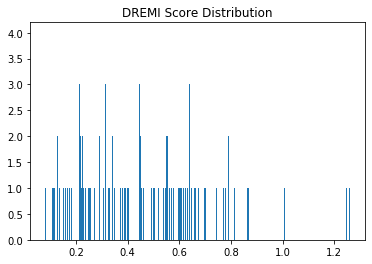

In [42]:
plt.hist(neighbor_dremi, bins=1000)
plt.title('DREMI Score Distribution')
plt.savefig('dremi_distribution', dpi=300)

### Ordering genes by highest to lowest attention, plot DREMI scores

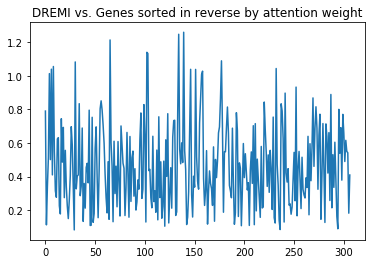

In [34]:
plt.plot(range(neighbor_dremi.shape[0]), neighbor_dremi[attention.argsort()[::-1]])
plt.title('DREMI vs. Genes sorted in reverse by attention weight')
plt.savefig('DREMI_vs_attention', dpi=300)

### Ordering genes by highest to lowest attention, plot DREMI scores for top 50 genes

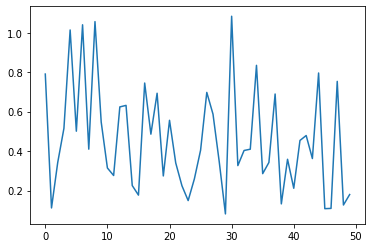

In [150]:
plt.plot(range(50), neighbor_dremi[attention.argsort()[::-1]][:50])

### Ordering genes by highest to lowest attention, plot cumulative mean DREMI score from first to all genes

In [203]:
top_dremi = []
for thresh in range(1,neighbor_dremi.shape[0]):
    top_dremi.append(np.mean(neighbor_dremi[attention.argsort()[::-1]][:thresh]))

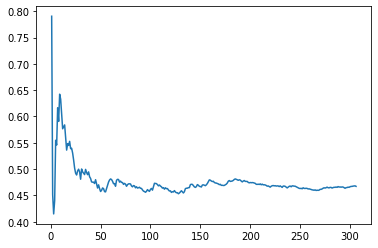

In [204]:
fig, axes = plt.subplots(1,1)
plt.plot(range(1,neighbor_dremi.shape[0]), top_dremi)

### Ordering genes randomly, plot cumulative mean DREMI score from first to all genes

In [199]:
import random

In [211]:
random_dremi = []
for r in range(10):
    r = []
    idx = list(range(neighbor_dremi.shape[0]))
    random.shuffle(idx)
    for thresh in range(1,neighbor_dremi.shape[0]):
        r.append(np.mean(neighbor_dremi[idx][:thresh]))
    random_dremi.append(r)

In [217]:
random_dremi = np.mean(np.array(random_dremi).reshape(10,neighbor_dremi.shape[0] - 1), axis=0)

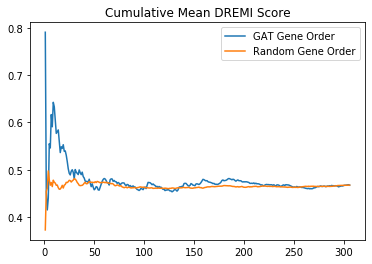

In [220]:
a, = plt.plot(range(1,neighbor_dremi.shape[0]), top_dremi)
b, = plt.plot(range(1,neighbor_dremi.shape[0]), random_dremi)
plt.title('Cumulative Mean DREMI Score')
plt.legend([a,b], ["GAT Gene Order", "Random Gene Order"])
plt.savefig('gene_order_mean', dpi=300)

## Visualization

In [22]:
phate_op = phate.PHATE()
count_df_phate = phate_op.fit_transform(count_df)

Calculating PHATE...
  Running PHATE on 1630 observations and 12116 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.72 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.30 seconds.
    Calculating affinities...
    Calculated affinities in 0.13 seconds.
  Calculated graph and diffusion operator in 2.23 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.74 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.36 seconds.
Calculated PHATE in 7.73 seconds.


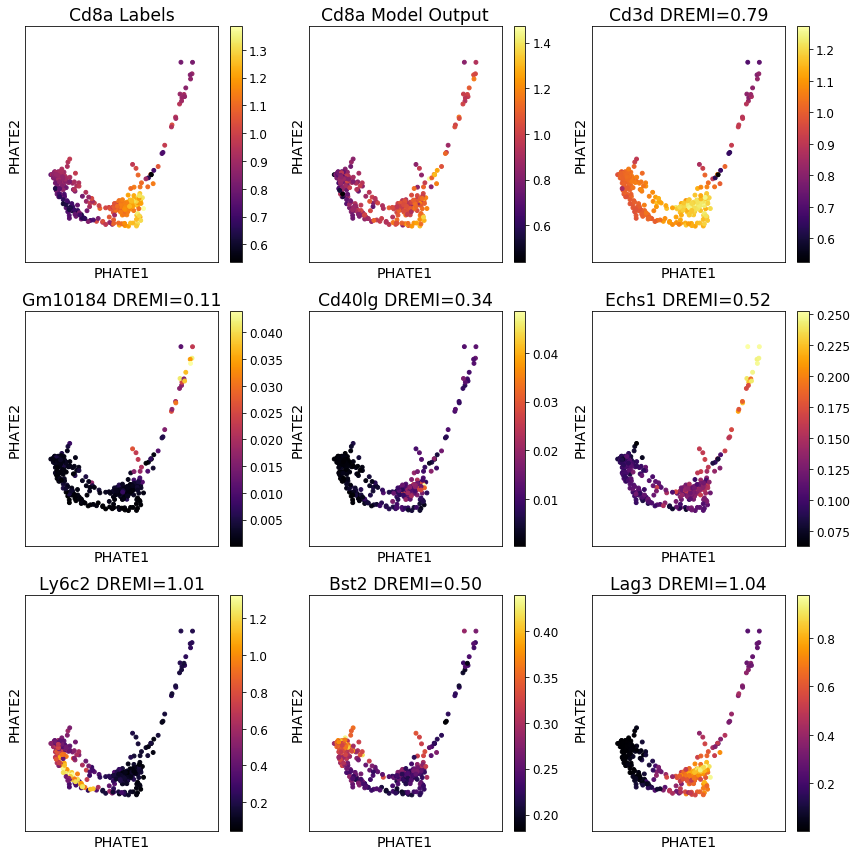

In [208]:
import scprep
fig, axes =plt.subplots(3,3, figsize=(12,12))
axes = axes.flatten()
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[0], s=15, c=labels_model.detach().numpy(),
                      title="Cd8a Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[1], s=15, c=output_model.detach().numpy(),
                      title="Cd8a Model Output",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[2], s=15, c=label_df[top_neighbor_genes[0]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[0]], neighbor_dremi[top_gene_idx][0]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[3], s=15, c=label_df[top_neighbor_genes[1]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[1]], neighbor_dremi[top_gene_idx][1]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[4], s=15, c=label_df[top_neighbor_genes[2]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[2]], neighbor_dremi[top_gene_idx][2]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[5], s=15, c=label_df[top_neighbor_genes[3]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[3]], neighbor_dremi[top_gene_idx][3]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[6], s=15, c=label_df[top_neighbor_genes[4]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[4]], neighbor_dremi[top_gene_idx][4]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[7], s=15, c=label_df[top_neighbor_genes[5]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[5]], neighbor_dremi[top_gene_idx][5]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[8], s=15, c=label_df[top_neighbor_genes[6]][idx_test],
                      title="{} DREMI={:.2f}".format(gene_symbol[top_neighbor_genes[6]], neighbor_dremi[top_gene_idx][6]),ticks=False, label_prefix="PHATE")
plt.tight_layout()

plt.savefig('top_attention_gene_vis', dpi=300)